In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

['imdb_master.csv']


In [2]:
import nltk
from collections import Counter
import itertools

In [3]:
import torch

In [4]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, label_id):
        self.input_ids = input_ids
        self.label_id = label_id

In [5]:
class Vocab:
    def __init__(self, itos, unk_index):
        self._itos = itos
        self._stoi = {word:i for i, word in enumerate(itos)}
        self._unk_index = unk_index
        
    def __len__(self):
        return len(self._itos)
    
    def word2id(self, word):
        idx = self._stoi.get(word)
        if idx is not None:
            return idx
        return self._unk_index
    
    def id2word(self, idx):
        return self._itos[idx]

In [6]:
from tqdm import tqdm_notebook

In [7]:
class TextToIdsTransformer:
    def transform():
        raise NotImplementedError()
        
    def fit_transform():
        raise NotImplementedError()

In [8]:
class SimpleTextTransformer(TextToIdsTransformer):
    def __init__(self, max_vocab_size):
        self.special_words = ['<PAD>', '</UNK>', '<S>', '</S>']
        self.unk_index = 1
        self.pad_index = 0
        self.vocab = None
        self.max_vocab_size = max_vocab_size
        
    def tokenize(self, text):
        return nltk.tokenize.word_tokenize(text.lower())
        
    def build_vocab(self, tokens):
        itos = []
        itos.extend(self.special_words)
        
        token_counts = Counter(tokens)
        for word, _ in token_counts.most_common(self.max_vocab_size - len(self.special_words)):
            itos.append(word)
            
        self.vocab = Vocab(itos, self.unk_index)
    
    def transform(self, texts):
        result = []
        for text in texts:
            tokens = ['<S>'] + self.tokenize(text) + ['</S>']
            ids = [self.vocab.word2id(token) for token in tokens]
            result.append(ids)
        return result
    
    def fit_transform(self, texts):
        result = []
        tokenized_texts = [self.tokenize(text) for text in texts]
        self.build_vocab(itertools.chain(*tokenized_texts))
        for tokens in tokenized_texts:
            tokens = ['<S>'] + tokens + ['</S>']
            ids = [self.vocab.word2id(token) for token in tokens]
            result.append(ids)
        return result


In [9]:
def build_features(token_ids, label, max_seq_len, pad_index, label_encoding):
    if len(token_ids) >= max_seq_len:
        ids = token_ids[:max_seq_len]
    else:
        ids = token_ids + [pad_index for _ in range(max_seq_len - len(token_ids))]
    return InputFeatures(ids, label_encoding[label])
        

In [10]:
def features_to_tensor(list_of_features):
    text_tensor = torch.tensor([example.input_ids for example in list_of_features], dtype=torch.long)
    labels_tensor = torch.tensor([example.label_id for example in list_of_features], dtype=torch.long)
    return text_tensor, labels_tensor

In [11]:
from sklearn import model_selection

In [12]:
imdb_df = pd.read_csv('../input/imdb_master.csv', encoding='latin-1')
dev_df = imdb_df[(imdb_df.type == 'train') & (imdb_df.label != 'unsup')]
test_df = imdb_df[(imdb_df.type == 'test')]
train_df, val_df = model_selection.train_test_split(dev_df, test_size=0.05, stratify=dev_df.label)

In [13]:
max_seq_len=200
classes = {'neg': 0, 'pos' : 1}

In [14]:
text2id = SimpleTextTransformer(10000)

train_ids = text2id.fit_transform(train_df['review'])
val_ids = text2id.transform(val_df['review'])
test_ids = text2id.transform(test_df['review'])

In [15]:
print(train_df.review.iloc[0][:160])
print(train_ids[0][:30])

This movie does not rock, as others have said. I found it really boring and silly. The story is about this metal high school kid who idolizes this really bad he
[2, 19, 26, 89, 36, 728, 5, 23, 408, 40, 311, 6, 18, 269, 16, 80, 373, 7, 689, 6, 4, 81, 11, 59, 19, 2657, 341, 411, 525, 49]


In [16]:
train_features = [build_features(token_ids, label,max_seq_len, text2id.pad_index, classes) 
                  for token_ids, label in zip(train_ids, train_df['label'])]

val_features = [build_features(token_ids, label,max_seq_len, text2id.pad_index, classes) 
                  for token_ids, label in zip(val_ids, val_df['label'])]

test_features = [build_features(token_ids, label,max_seq_len, text2id.pad_index, classes) 
                  for token_ids, label in zip(test_ids, test_df['label'])]

In [17]:
print(train_features[3].input_ids)

[2, 19, 26, 22, 4, 136, 26, 18, 40, 141, 130, 6, 129, 8625, 18, 544, 387, 19, 26, 105, 31, 37, 503, 10, 247, 8, 69, 1820, 59, 4, 138, 9, 2107, 1191, 6, 272, 4, 26, 22, 36, 112, 24, 544, 5741, 172, 16, 11, 8, 1717, 7, 138, 2620, 26, 20, 75, 41, 504, 7, 2734, 47, 307, 6, 18, 226, 19, 26, 24, 72, 235, 7, 18, 75, 2054, 2380, 20, 86, 40, 45, 82, 8, 652, 9, 526, 6, 19, 26, 1946, 99, 10, 80, 389, 108, 281, 4, 138, 22, 25, 4, 8958, 7, 108, 94, 1, 38, 22, 3499, 24, 6, 119, 18, 226, 19, 26, 5, 54, 22, 36, 8, 699, 2255, 847, 17, 4, 435, 677, 6, 307, 22, 2777, 47, 63, 46, 226, 7, 18, 40, 36, 97, 4, 187, 250, 18, 40, 130, 16, 6, 18, 544, 387, 19, 26, 25, 307, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [18]:
train_tensor, train_labels = features_to_tensor(train_features)
val_tensor, val_labels = features_to_tensor(val_features)
test_tensor, test_labels = features_to_tensor(test_features)

In [19]:
print(train_tensor.size())

torch.Size([23750, 200])


In [20]:
print(len(text2id.vocab))

10000


In [21]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)


1.13.1


In [22]:
vocab_size = 10000
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
history = model.fit(train_tensor,train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_data=(val_tensor,val_labels),
                    verbose=1)

Train on 23750 samples, validate on 1250 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
23750/23750 [==============================] - 2s 66us/sample - loss: 0.6889 - acc: 0.6264 - val_loss: 0.6827 - val_acc: 0.6920
Epoch 2/40
23750/23750 [==============================] - 1s 49us/sample - loss: 0.6679 - acc: 0.7142 - val_loss: 0.6508 - val_acc: 0.7280
Epoch 3/40
23750/23750 [==============================] - 1s 55us/sample - loss: 0.6207 - acc: 0.7538 - val_loss: 0.5938 - val_acc: 0.7704
Epoch 4/40
23750/23750 [==============================] - 1s 54us/sample - loss: 0.5532 - acc: 0.7971 - val_loss: 0.5255 - val_acc: 0.8008
Epoch 5/40
23750/23750 [==============================] - 1s 55us/sample - loss: 0.4814 - acc: 0.8282 - val_loss: 0.4625 - val_acc: 0.8296
Epoch 6/40
23750/23750 [==============================] - 1s 55us/sample - loss: 0.4201 - acc: 0.8487 - val_loss: 0.4149 - val_acc: 0.8432
Epoch 7/40
23750/23750 [==============================] - 1s 55us/sam

In [25]:
results = model.evaluate(test_tensor, test_labels)

print(results)

25000/25000 [==============================] - 1s 49us/sample - loss: 0.5320 - acc: 0.8276
[0.5319748107498884, 0.82756]


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

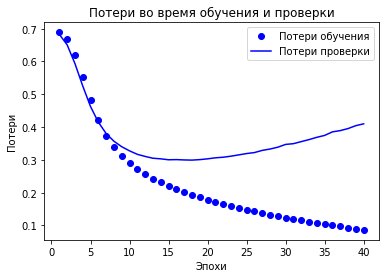

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" означает "blue dot", синяя точка
plt.plot(epochs, loss, 'bo', label='Потери обучения')
# "b" означает "solid blue line", непрерывная синяя линия
plt.plot(epochs, val_loss, 'b', label='Потери проверки')
plt.title('Потери во время обучения и проверки')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.show()

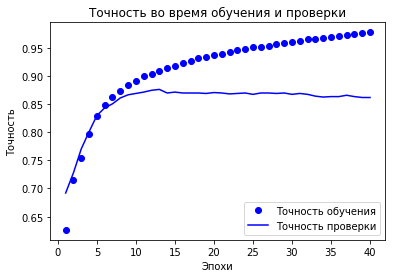

In [28]:
plt.clf()   # Очистим график
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Точность обучения')
plt.plot(epochs, val_acc, 'b', label='Точность проверки')
plt.title('Точность во время обучения и проверки')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

plt.show()